In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/batches.meta
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/test_batch
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/readme.html


In [2]:
import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [3]:
DATA_ROOT = "/kaggle/input/cifar-10-dataset"

transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

transform_val = T.Compose([
    T.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=False,   # IMPORTANT: Kaggle already has the data
    transform=transform_train,
)

val_dataset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT,
    train=False,
    download=False,
    transform=transform_val,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)


In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.norm2 = nn.LayerNorm(dim)

        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x), need_weights=False)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x


In [5]:
#sanity check, should output 50000 10000
print(len(train_dataset), len(val_dataset))


50000 10000


In [6]:
class ViTSmall(nn.Module):
    def __init__(
        self,
        image_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=384,
        depth=12,
        num_heads=6,
        mlp_ratio=4.0,
        dropout=0.1,
    ):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim)
        )
        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim, num_heads, mlp_ratio, dropout
            )
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return self.head(x[:, 0])


In [7]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        total += x.size(0)
    return total_loss / total


def train_n_batches(model, optimizer, loader, n_batches):
    model.train()
    it = iter(loader)
    for _ in range(n_batches):
        try:
            x, y = next(it)
        except StopIteration:
            it = iter(loader)
            x, y = next(it)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = F.cross_entropy(model(x), y)
        loss.backward()
        optimizer.step()


In [8]:
class HyperGradient:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        lr=3.3e-4,
        wd=0.07,
        delta=1e-4,
        hyper_lr=1e-6,  # CHANGED: Reduced default from 1e-2 to 1e-6
        probe_batches=5
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.lr = lr
        self.wd = wd
        self.delta = delta
        self.hyper_lr = hyper_lr
        self.probe_batches = probe_batches

    def _make_opt(self, model, lr, wd):
        return torch.optim.AdamW(
            model.parameters(), lr=lr, weight_decay=wd
        )

    # NEW: Helper to evaluate faster
    @torch.no_grad()
    def evaluate_subset(self, model, loader, limit_batches=20):
        model.eval()
        total_loss, total = 0.0, 0
        for i, (x, y) in enumerate(loader):
            if i >= limit_batches: break
            x, y = x.to(device), y.to(device)
            loss = F.cross_entropy(model(x), y)
            total_loss += loss.item() * x.size(0)
            total += x.size(0)
        return total_loss / total

    def step(self):
        grads = {}

        for name in ["lr", "wd"]:
            base = getattr(self, name)
            # Ensure epsilon isn't too tiny
            eps = self.delta * max(base, 1e-8)

            losses = {}
            for sign in [+1, -1]:
                val = max(base + sign * eps, 1e-8)
                clone = copy.deepcopy(self.model)
                opt = self._make_opt(
                    clone,
                    lr=val if name == "lr" else self.lr,
                    wd=val if name == "wd" else self.wd,
                )

                train_n_batches(
                    clone, opt, self.train_loader, self.probe_batches
                )
                # CHANGED: Use fast subset evaluation
                losses[sign] = self.evaluate_subset(clone, self.val_loader, limit_batches=20)

            grads[name] = (losses[+1] - losses[-1]) / (2 * eps)

        # CHANGED: Robust Update Logic with Clipping
        # 1. Update LR with safety clip
        lr_grad = grads["lr"]
        lr_update = self.hyper_lr * lr_grad
        # Cap change to max 20% of current value to prevent explosion
        max_lr_change = 0.20 * self.lr
        if abs(lr_update) > max_lr_change:
            lr_update = max_lr_change if lr_update > 0 else -max_lr_change
        
        self.lr -= lr_update

        # 2. Update WD with safety clip
        wd_grad = grads["wd"]
        wd_update = self.hyper_lr * wd_grad
        max_wd_change = 0.20 * self.wd
        if abs(wd_update) > max_wd_change:
            wd_update = max_wd_change if wd_update > 0 else -max_wd_change
            
        self.wd -= wd_update

        # 3. Final Clamps
        self.lr = float(torch.clamp(torch.tensor(self.lr), 1e-6, 1e-2))
        self.wd = float(torch.clamp(torch.tensor(self.wd), 1e-6, 1.0))

        return grads

In [9]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# We use fewer seeds per ablation to keep runtime reasonable (~1.5 hours total)
# If you have 9 hours of Kaggle time, you can add more seeds.
SEEDS = [38042, 217401] 
ABLATION_VALUES = [0.0, 1e-10, 1e-8, 1e-6] # The specific values to test

EPOCHS = 70 # Reduced from 90 to 70 for faster ablation feedback
HYPER_INTERVAL = 2  

full_data_log = []

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

@torch.no_grad()
def evaluate_metrics(model, loader):
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        _, preds = logits.max(1)
        correct += preds.eq(y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

# ==========================================
# 3. MAIN ABLATION LOOP
# ==========================================
print(f"Starting Ablation Experiment.")
print(f"Comparing HyperLRs: {ABLATION_VALUES}")

for h_lr in ABLATION_VALUES:
    print(f"\n{'#'*70}")
    print(f"PROCESSING ABLATION GROUP: hyper_lr = {h_lr}")
    print(f"{'#'*70}")
    
    for seed in SEEDS:
        print(f"--> Running Seed {seed}...")
        set_seed(seed)
        
        # Init Model
        model = ViTSmall(
            image_size=32, patch_size=8, embed_dim=192,
            depth=12, num_heads=3, mlp_ratio=4.0, dropout=0.1
        ).to(device)

        # Init HyperGradient with CURRENT ABLATION VALUE
        hg = HyperGradient(
            model, train_loader, val_loader,
            lr=3.3e-4, wd=0.07,
            hyper_lr=h_lr  # <--- CRITICAL CHANGE
        )

        optimizer = torch.optim.AdamW(model.parameters(), lr=hg.lr, weight_decay=hg.wd)

        for epoch in range(EPOCHS):
            t0 = time.time()
            model.train()
            
            # Batch Loop
            running_loss, seen = 0.0, 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = F.cross_entropy(model(x), y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * x.size(0)
                seen += x.size(0)
            
            # Hyper Step
            if epoch % HYPER_INTERVAL == 0:
                hg.step()
                for pg in optimizer.param_groups:
                    pg['lr'] = hg.lr
                    pg['weight_decay'] = hg.wd

            # Validation
            val_loss, val_acc = evaluate_metrics(model, val_loader)
            
            # Log
            full_data_log.append({
                'HyperLR_Group': str(h_lr), # Convert to string for better plotting labels
                'Seed': seed,
                'Epoch': epoch,
                'Train_Loss': running_loss / seen,
                'Val_Acc': val_acc,
                'LR': hg.lr,
                'WD': hg.wd
            })
            
            if epoch % 10 == 0:
                print(f"   Ep {epoch} | Val Acc: {val_acc:.1%} | LR: {hg.lr:.2e}")

# Save Final Results
df = pd.DataFrame(full_data_log)
df.to_csv("ablation_results.csv", index=False)
print("Ablation Complete. Data saved to ablation_results.csv")

Starting Ablation Experiment.
Comparing HyperLRs: [0.0, 1e-10, 1e-08, 1e-06]

######################################################################
PROCESSING ABLATION GROUP: hyper_lr = 0.0
######################################################################
--> Running Seed 38042...
   Ep 0 | Val Acc: 30.4% | LR: 3.30e-04
   Ep 10 | Val Acc: 49.9% | LR: 3.30e-04
   Ep 20 | Val Acc: 54.6% | LR: 3.30e-04
   Ep 30 | Val Acc: 59.1% | LR: 3.30e-04
   Ep 40 | Val Acc: 63.5% | LR: 3.30e-04
   Ep 50 | Val Acc: 68.0% | LR: 3.30e-04
   Ep 60 | Val Acc: 69.4% | LR: 3.30e-04
--> Running Seed 217401...
   Ep 0 | Val Acc: 36.6% | LR: 3.30e-04
   Ep 10 | Val Acc: 50.6% | LR: 3.30e-04
   Ep 20 | Val Acc: 55.3% | LR: 3.30e-04
   Ep 30 | Val Acc: 60.0% | LR: 3.30e-04
   Ep 40 | Val Acc: 64.4% | LR: 3.30e-04
   Ep 50 | Val Acc: 67.7% | LR: 3.30e-04
   Ep 60 | Val Acc: 69.0% | LR: 3.30e-04

######################################################################
PROCESSING ABLATION GROUP: hyper_lr = 1e-

ValueError: The palette dictionary is missing keys: {0.0, 1e-08, 1e-10, 1e-06}

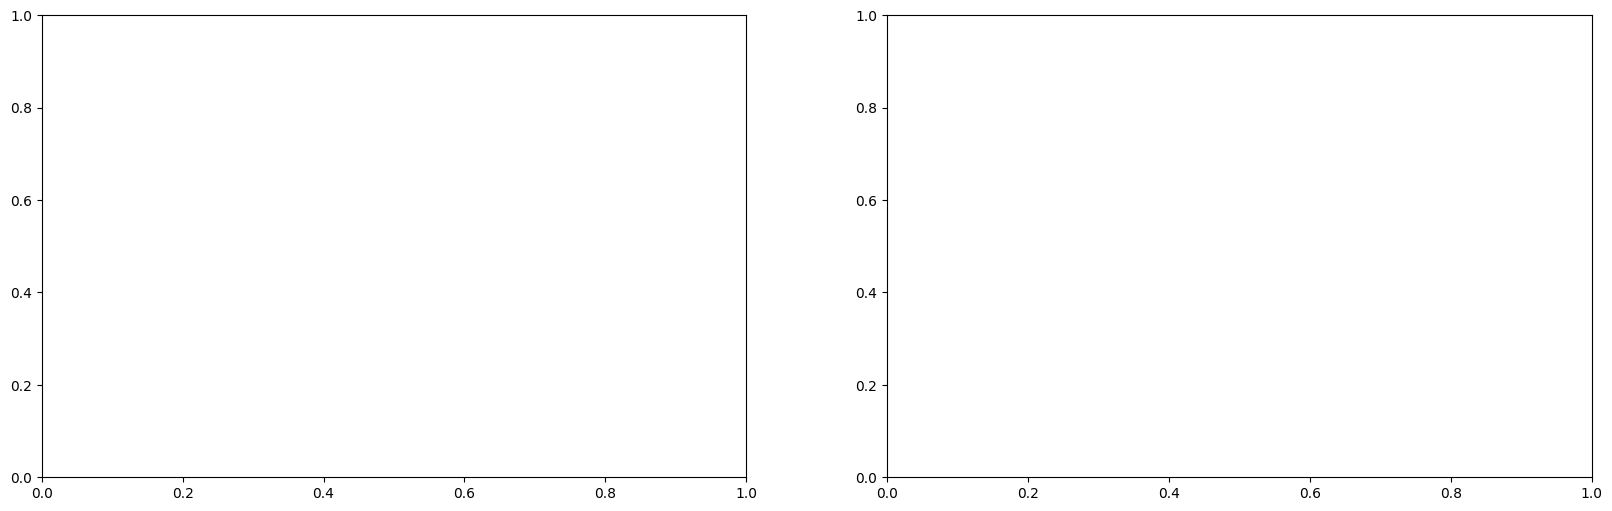

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the data we just saved
df = pd.read_csv("ablation_results.csv")

# Setup layout
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Define colors for clarity
palette = {
    '0.0': "gray",      # Baseline
    '1e-10': "green",   # Smooth
    '1e-08': "blue",    # Moderate
    '1e-06': "red"      # Chaotic
}

# Plot 1: Validation Accuracy
sns.lineplot(
    data=df, x="Epoch", y="Val_Acc", hue="HyperLR_Group", 
    palette=palette, ax=axes[0], linewidth=2
)
axes[0].set_title("Validation Accuracy by Hyper-LR")
axes[0].grid(True, alpha=0.3)

# Plot 2: Learning Rate Dynamics
sns.lineplot(
    data=df, x="Epoch", y="LR", hue="HyperLR_Group", 
    palette=palette, ax=axes[1], linewidth=2
)
axes[1].set_title("Learning Rate Adaptation")
axes[1].set_yscale("log") # Log scale to see the magnitude differences
axes[1].grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.savefig("ablation_chart.png")
plt.show()